## Stage 1: Exploratory Data Analysis

# Setup & Data Loading

In [554]:
# Import needed packages
import ast
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from gensim.models import Word2Vec
from collections import Counter
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.stats import skew, kurtosis

In [555]:
# Load the preprocessed data
cleaned_data = pd.read_csv('../data/checkpoints/enriched_cleaned_data.csv', delimiter = '|')

In [556]:
# Set the theme and figisze for a unique plot appearence
sns.set_theme(style='whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)

# Data Preparation & simple Feature Engineering

In [557]:
# Define a function to convert a string representation of a list to a list datatype
def string_to_list(string):
    try:
        return ast.literal_eval(string)
    except (ValueError, SyntaxError):
        print('List conversion failed')
        return []

# Convert the string representations of the lists to the correct 'list' datatype
cleaned_data['word_tokens'] = cleaned_data['word_tokens'].apply(string_to_list)
cleaned_data['sentence_tokens'] = cleaned_data['sentence_tokens'].apply(string_to_list)
cleaned_data['pos_tagged_word_tokens'] = cleaned_data['pos_tagged_word_tokens'].apply(string_to_list)
cleaned_data['pos_tagged_sentence_tokens'] = cleaned_data['pos_tagged_sentence_tokens'].apply(string_to_list)
cleaned_data['esg_topics'] = cleaned_data['esg_topics'].apply(string_to_list)

In [558]:
# Add some count features for the analysis
cleaned_data['cnt_word'] = cleaned_data['word_tokens'].apply(len)
cleaned_data['cnt_sentence'] = cleaned_data['sentence_tokens'].apply(len)
cleaned_data['cnt_esg'] = cleaned_data['esg_topics'].apply(len)

# Calculate ratio between words/sentences
cleaned_data['ratio_word_sentence'] = cleaned_data['cnt_word'] / cleaned_data['cnt_sentence']

In [559]:
# Convert date to correct datatype
cleaned_data['date'] = pd.to_datetime(cleaned_data['date'])

# Derive year and month to aggregate
cleaned_data['year_month'] = cleaned_data['date'].apply(lambda x: x.strftime('%Y-%m'))
cleaned_data['year'] = cleaned_data['date'].apply(lambda x: x.strftime('%Y'))
cleaned_data['month'] = cleaned_data['date'].apply(lambda x: x.strftime('%m'))

In [560]:
# Check the data with a few samples
cleaned_data.sample(5)

company datatype       date          domain   
3948         Deutsche Bank  general 2022-01-27          law360  \
9700  Siemens Healthineers  general 2021-10-02       itnonline   
1928                   BMW     tech 2021-03-29  digitaljournal   
8855               Siemens  general 2022-09-27         txfnews   
4082         Deutsche Bank      NaN 2022-05-02             wsj   

                                       esg_topics  internal symbol   
3948                                      [Fraud]         0    DBK  \
9700                    [Social, GenderDiversity]         0    SHL   
1928         [Coal, Environment, GenderDiversity]         0    BMW   
8855                  [WindEnergy, ESGDisclosure]         0    SIE   
4082  [EMobility, Governance, Antitrust, Vaccine]         0    DBK   

                                                  title   
3948  2nd Circ. Reverses Deutsche Bank Traders ' Lib...  \
9700  Siemens Healthineers Showcases New In Vivo and...   
1928  'Trash is gold ' as Benin community turns wast...   
8855  Nova Scotia to offer offshore wind leases from...   
4082  EU Antitrust Chief: Apple ‘ Abused’ Mobile-Pay...   

                                        cleaned_content   
3948  rigging deeming evidence trial insufficient pr...  \
9700  transcatheter cardiovascular therapeutic tct c...   
1928  hi looking published garbage never smelled swe...   
8855  offshore wind acen divestment south luzon coal...   
4082  photo fourth dos covid vaccine roll questionin...   

                                            word_tokens  ...   
3948  [rigging, deeming, evidence, trial, insufficie...  ...  \
9700  [transcatheter, cardiovascular, therapeutic, t...  ...   
1928  [hi, looking, published, garbage, never, smell...  ...   
8855  [offshore, wind, acen, divestment, south, luzo...  ...   
4082  [photo, fourth, dos, covid, vaccine, roll, que...  ...   

                      sector                        industry sentiment_value   
3948              Financials                           Banks        0.012300  \
9700              Healthcare          Diagnostics & Research        0.420600   
1928  Consumer Discretionary              Auto Manufacturers        0.073874   
8855             Industrials  Specialty Industrial Machinery        0.206029   
4082              Financials                           Banks        0.149373   

      cnt_word cnt_sentence cnt_esg  ratio_word_sentence  year_month  year   
3948        46            3       1            15.333333     2022-01  2022  \
9700       272            9       2            30.222222     2021-10  2021   
1928       745           74       3            10.067568     2021-03  2021   
8855       142            7       2            20.285714     2022-09  2022   
4082       202           22       4             9.181818     2022-05  2022   

      month  
3948     01  
9700     10  
1928     03  
8855     09  
4082     05  

[5 rows x 24 columns]

# General Descriptive Analysis

In [561]:
# Define a function to plot histograms and boxplots
def plot_basic_hist_and_box(column, data):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    sns.histplot(data[column], kde=True)
    plt.title(f'Histogram of {column}')
    plt.subplot(1, 2, 2)
    sns.boxplot(x=data[column])
    plt.title(f'Boxplot of {column}')
    plt.show()

# Calculate measures of central tendency, skewness, and kurtosis
def calculate_basic_statistical_properties(column, data):
    mean = data[column].mean()
    median = data[column].median()
    mode = data[column].mode().values[0]
    skewness = skew(data[column].dropna())
    kurt = kurtosis(data[column].dropna())
    
    print(f'Mean: {round(mean,2)}\nMedian: {round(median,2)}\nMode: {round(mode,2)}\nSkewness: {round(skewness,2)}\nKurtosis: {round(kurt,2)}')

# Measures of dispersion (range, interquartile range, variance, and standard deviation)
def calulate_dispersion_measures(column, data):
    min_value = data[column].min()
    max_value = data[column].max()
    range_value = max_value - min_value
    q1 = data[column].quantile(0.25)
    q3 = data[column].quantile(0.75)
    iqr = q3 - q1
    variance = data[column].var()
    std_dev = data[column].std()
    
    print(f'Range: {round(range_value,2)}\nInterquartile Range: {round(iqr,2)}\nVariance: {round(variance,2)}\nStandard Deviation: {round(std_dev,2)}')

### Basic Statistical Metrics of Reports by Words

Mean: 913.31
Median: 329.0
Mode: 257
Skewness: 13.84
Kurtosis: 226.53
Range: 122419
Interquartile Range: 329.0
Variance: 22806456.23
Standard Deviation: 4775.61


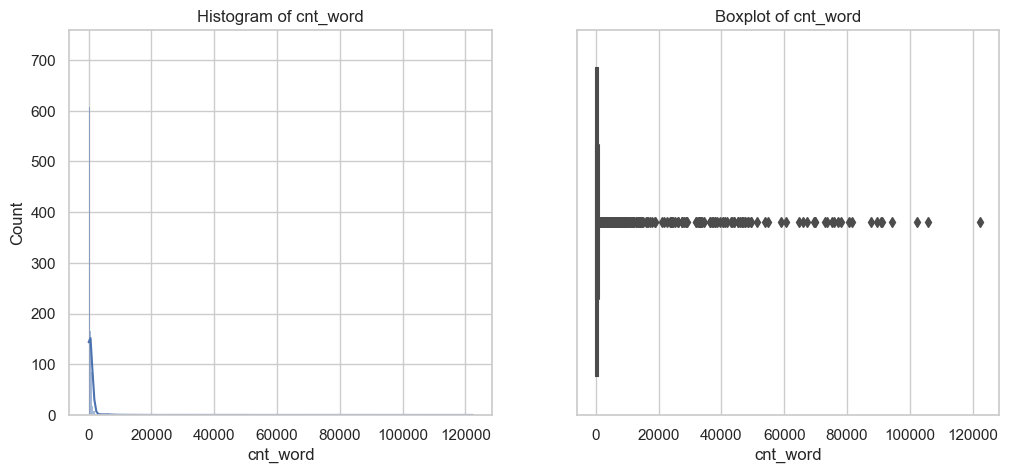

In [562]:
calculate_basic_statistical_properties('cnt_word', cleaned_data)
calulate_dispersion_measures('cnt_word', cleaned_data)
plot_basic_hist_and_box('cnt_word', cleaned_data)

Mean: 62.11
Median: 23.0
Mode: 12
Skewness: 13.23
Kurtosis: 207.41
Range: 7327
Interquartile Range: 26.0
Variance: 86837.85
Standard Deviation: 294.68


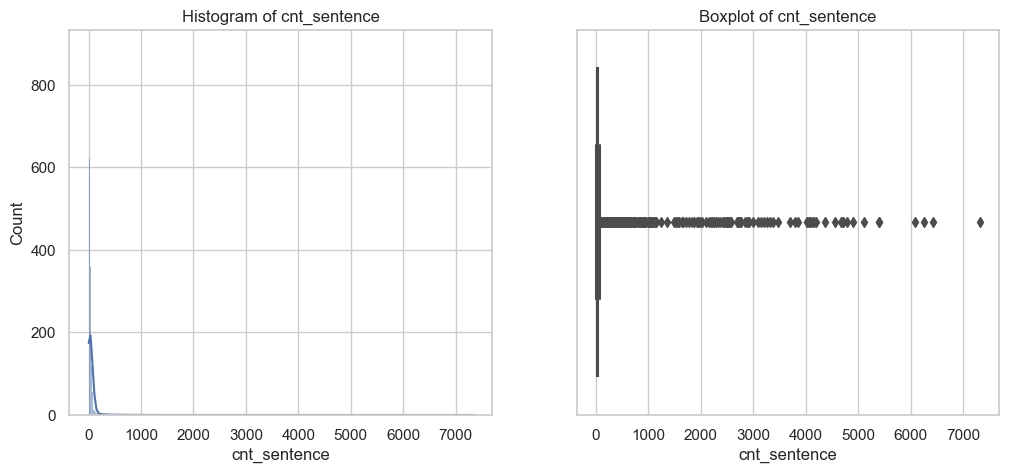

In [563]:
calculate_basic_statistical_properties('cnt_sentence', cleaned_data)
calulate_dispersion_measures('cnt_sentence', cleaned_data)
plot_basic_hist_and_box('cnt_sentence', cleaned_data)

Mean: 569.71
Median: 326.0
Mode: 257
Skewness: 17.63
Kurtosis: 451.11
Range: 60492
Interquartile Range: 319.0
Variance: 2628899.94
Standard Deviation: 1621.39


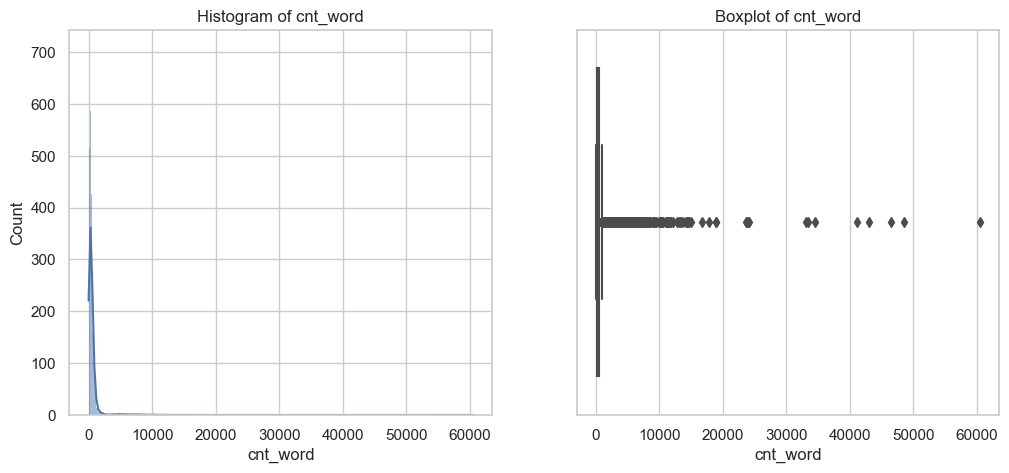

In [564]:
calculate_basic_statistical_properties('cnt_word', cleaned_data[cleaned_data.internal == 0])
calulate_dispersion_measures('cnt_word', cleaned_data[cleaned_data.internal == 0])
plot_basic_hist_and_box('cnt_word', cleaned_data[cleaned_data.internal == 0])

Mean: 42371.97
Median: 37805.0
Mode: 2289
Skewness: 0.69
Kurtosis: -0.1
Range: 120133
Interquartile Range: 32354.0
Variance: 732176035.97
Standard Deviation: 27058.75


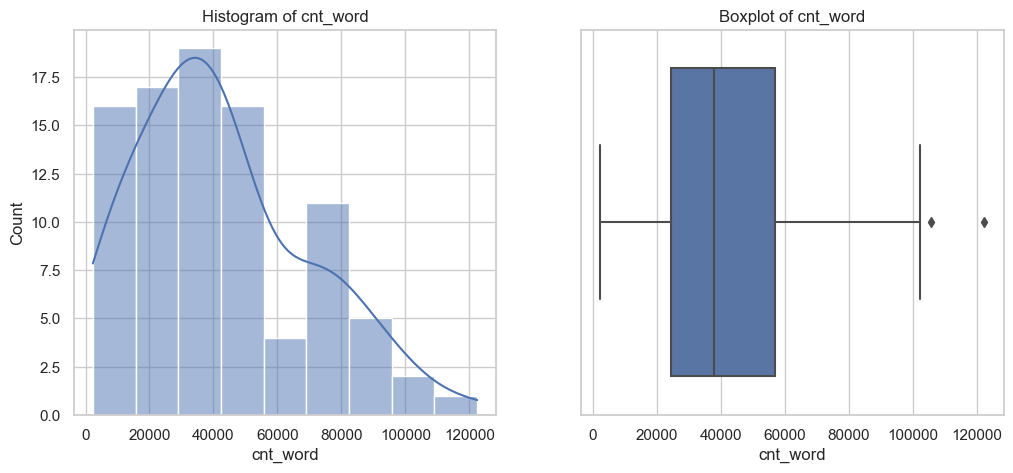

In [565]:
calculate_basic_statistical_properties('cnt_word', cleaned_data[cleaned_data.internal == 1])
calulate_dispersion_measures('cnt_word', cleaned_data[cleaned_data.internal == 1])
plot_basic_hist_and_box('cnt_word', cleaned_data[cleaned_data.internal == 1])

# Text Specific Analysis

### Datatype (Report Type) Amount

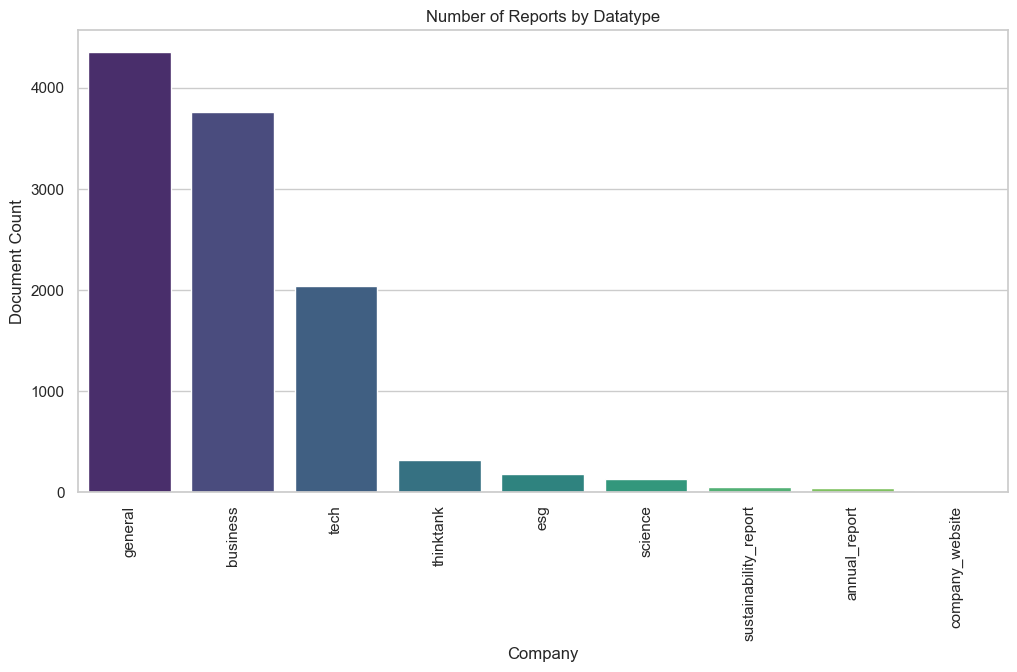

In [566]:
count_datatype = cleaned_data['datatype'].value_counts()

plt.figure(figsize=(12, 6))
sns.barplot(x=count_datatype.index, y=count_datatype.values, palette='viridis')
plt.title('Number of Reports by Datatype')
plt.xlabel('Company')
plt.ylabel('Document Count')
plt.xticks(rotation=90)
plt.show()

### Number of Reports by Company, Sector and Industry

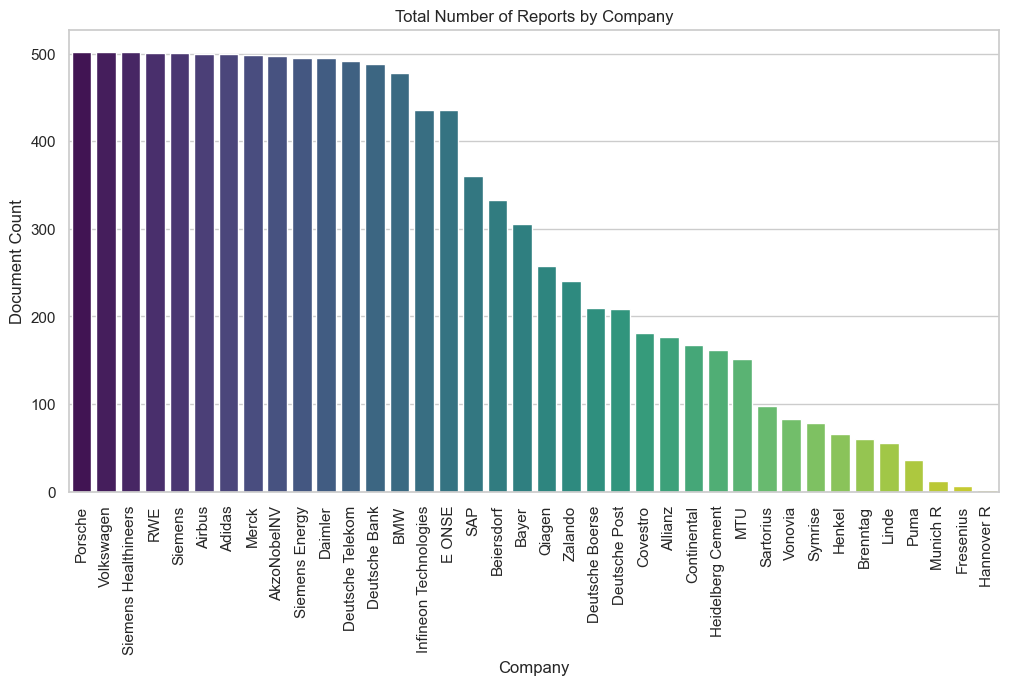

In [567]:
count_datatype = cleaned_data['company'].value_counts()

plt.figure(figsize=(12, 6))
sns.barplot(x=count_datatype.index, y=count_datatype.values, palette='viridis')
plt.title('Total Number of Reports by Company')
plt.xlabel('Company')
plt.ylabel('Document Count')
plt.xticks(rotation=90)
plt.show()

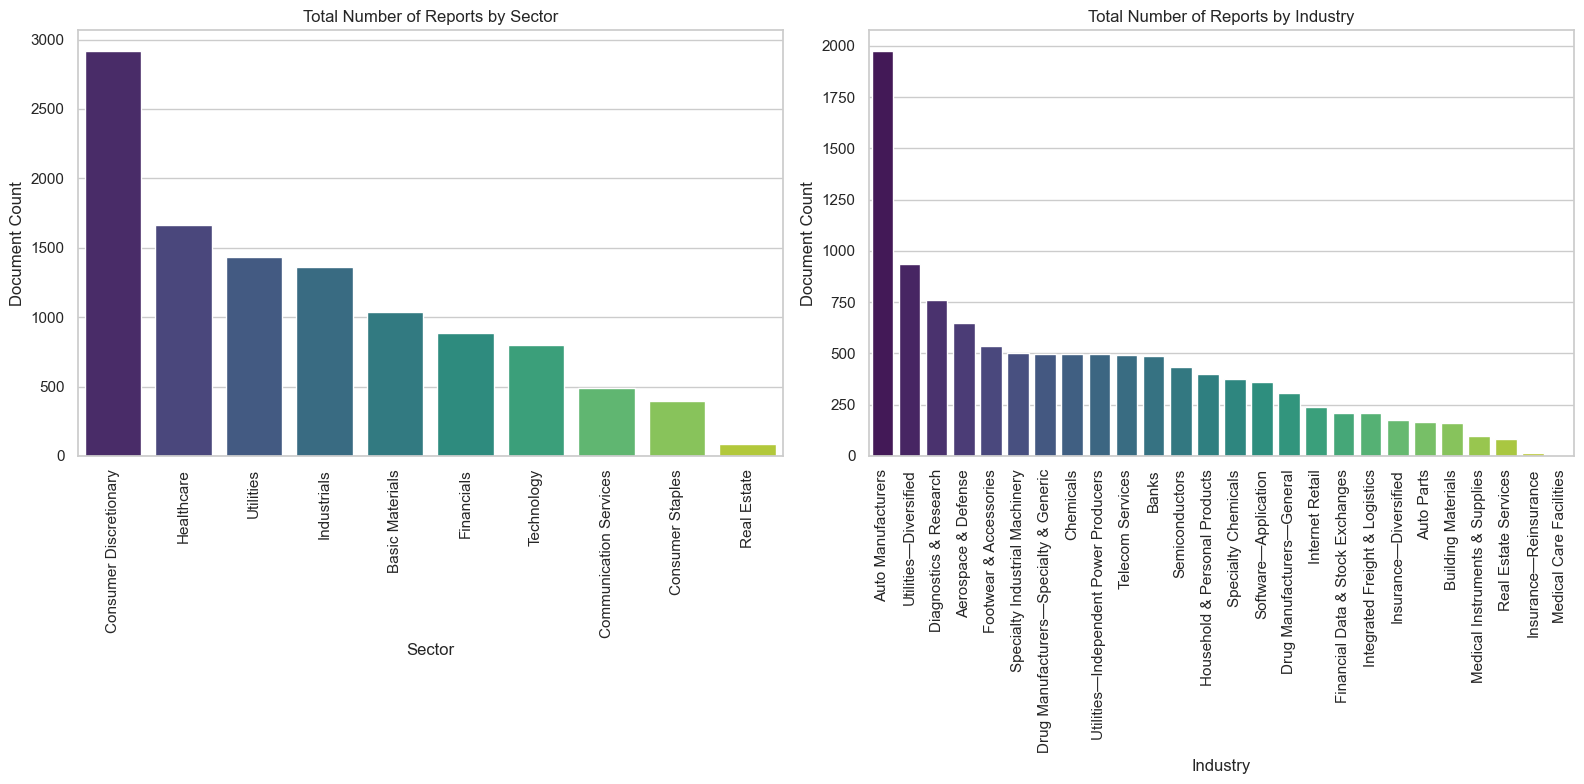

In [568]:
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Total Number of Reports by Company
count_company = cleaned_data['sector'].value_counts()
sns.barplot(x=count_company.index, y=count_company.values, palette='viridis', ax=axes[0])
axes[0].set_title('Total Number of Reports by Sector')
axes[0].set_xlabel('Sector')
axes[0].set_ylabel('Document Count')
axes[0].tick_params(axis='x', rotation=90)

# Total Number of Reports by Industry
count_industry = cleaned_data['industry'].value_counts()
sns.barplot(x=count_industry.index, y=count_industry.values, palette='viridis', ax=axes[1])
axes[1].set_title('Total Number of Reports by Industry')
axes[1].set_xlabel('Industry')
axes[1].set_ylabel('Document Count')
axes[1].tick_params(axis='x', rotation=90)

plt.tight_layout()
plt.show()

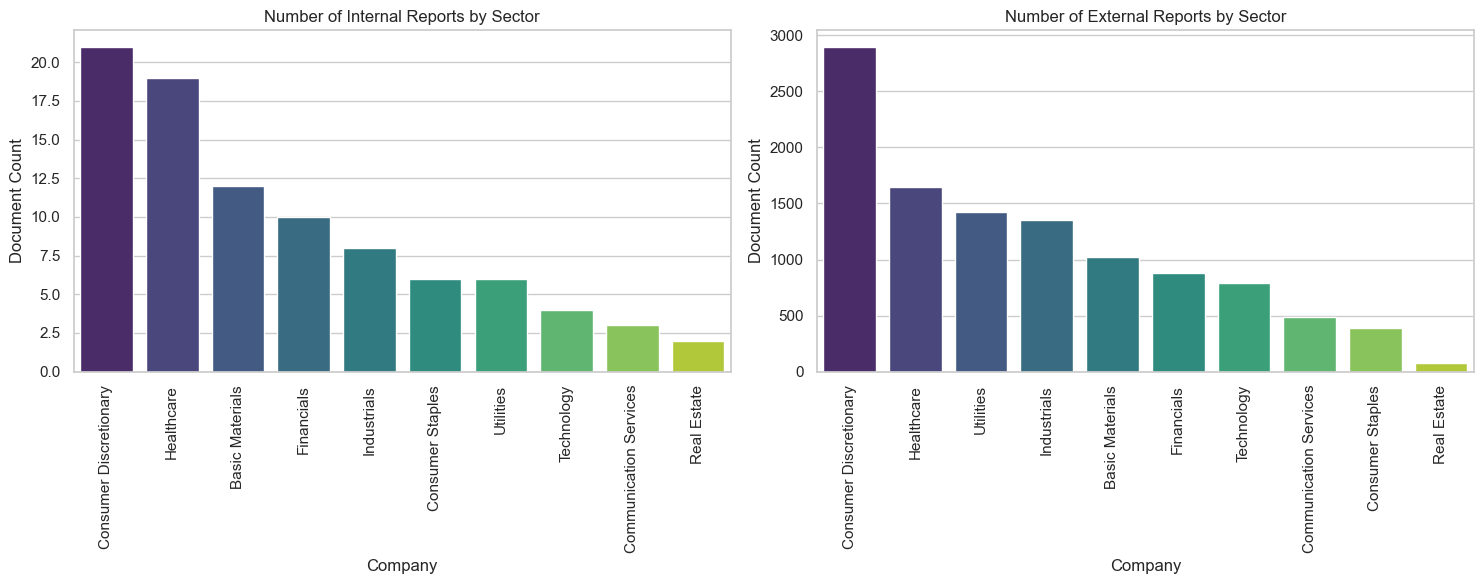

In [569]:
internal_data = cleaned_data[cleaned_data['internal'] == 1]
external_data = cleaned_data[cleaned_data['internal'] == 0]

count_internal_datatype = internal_data['sector'].value_counts()
count_external_datatype = external_data['sector'].value_counts()

plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
sns.barplot(x=count_internal_datatype.index, y=count_internal_datatype.values, palette='viridis')
plt.title('Number of Internal Reports by Sector')
plt.xlabel('Company')
plt.ylabel('Document Count')
plt.xticks(rotation=90)

plt.subplot(1, 2, 2)
sns.barplot(x=count_external_datatype.index, y=count_external_datatype.values, palette='viridis')
plt.title('Number of External Reports by Sector')
plt.xlabel('Company')
plt.ylabel('Document Count')
plt.xticks(rotation=90)

plt.tight_layout()
plt.show()

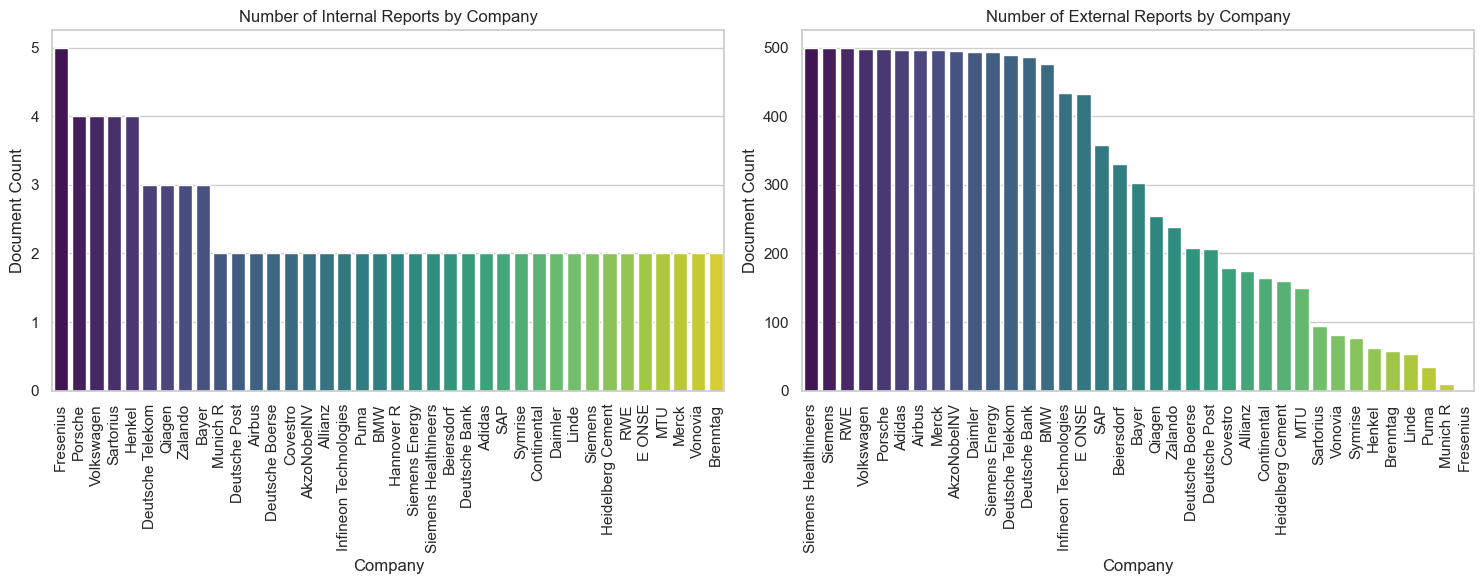

In [570]:
internal_data = cleaned_data[cleaned_data['internal'] == 1]
external_data = cleaned_data[cleaned_data['internal'] == 0]

count_internal_datatype = internal_data['company'].value_counts()
count_external_datatype = external_data['company'].value_counts()

plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
sns.barplot(x=count_internal_datatype.index, y=count_internal_datatype.values, palette='viridis')
plt.title('Number of Internal Reports by Company')
plt.xlabel('Company')
plt.ylabel('Document Count')
plt.xticks(rotation=90)

plt.subplot(1, 2, 2)
sns.barplot(x=count_external_datatype.index, y=count_external_datatype.values, palette='viridis')
plt.title('Number of External Reports by Company')
plt.xlabel('Company')
plt.ylabel('Document Count')
plt.xticks(rotation=90)

plt.tight_layout()
plt.show()

## Internal vs. External Report

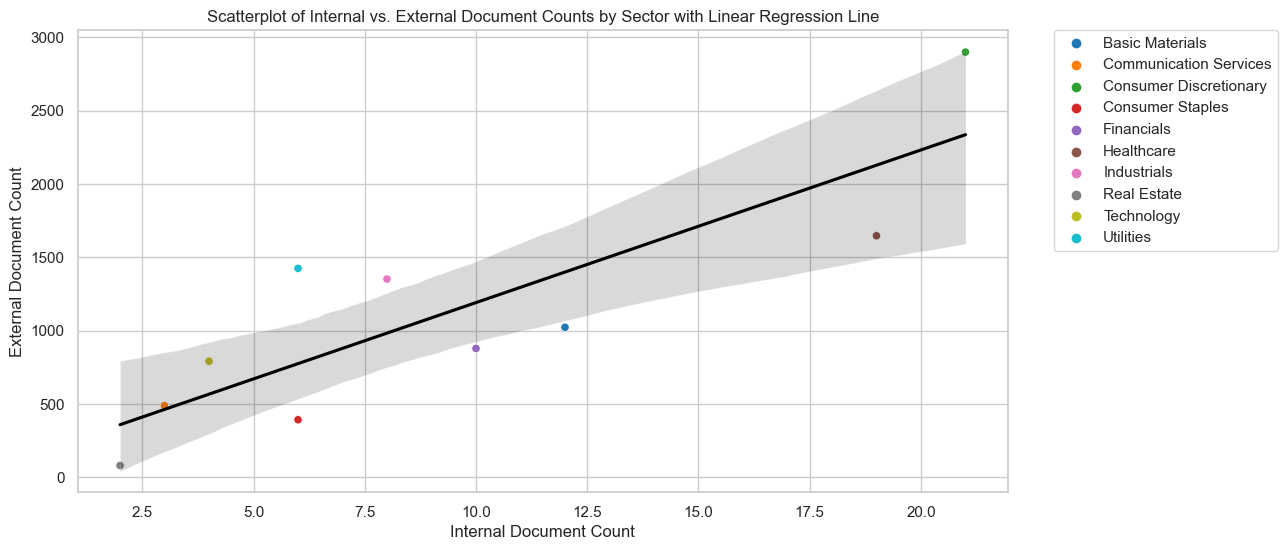

In [571]:
internal_data = cleaned_data[cleaned_data['internal'] == 1]
external_data = cleaned_data[cleaned_data['internal'] == 0]

count_internal_datatype = internal_data.groupby('sector')['company'].count()
count_external_datatype = external_data.groupby('sector')['company'].count()

# Create a new DataFrame with internal and external document counts for each sector
doc_counts = pd.DataFrame({'internal_count': count_internal_datatype, 'external_count': count_external_datatype})
doc_counts = doc_counts.reset_index()

plt.figure(figsize=(12, 6))
sns.scatterplot(data=doc_counts, x='internal_count', y='external_count', hue='sector', palette='tab10')
sns.regplot(data=doc_counts, x='internal_count', y='external_count', scatter=False, color='black')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.title('Scatterplot of Internal vs. External Document Counts by Sector with Linear Regression Line')
plt.xlabel('Internal Document Count')
plt.ylabel('External Document Count')
plt.show()

# Normalize with cnt compand in sector

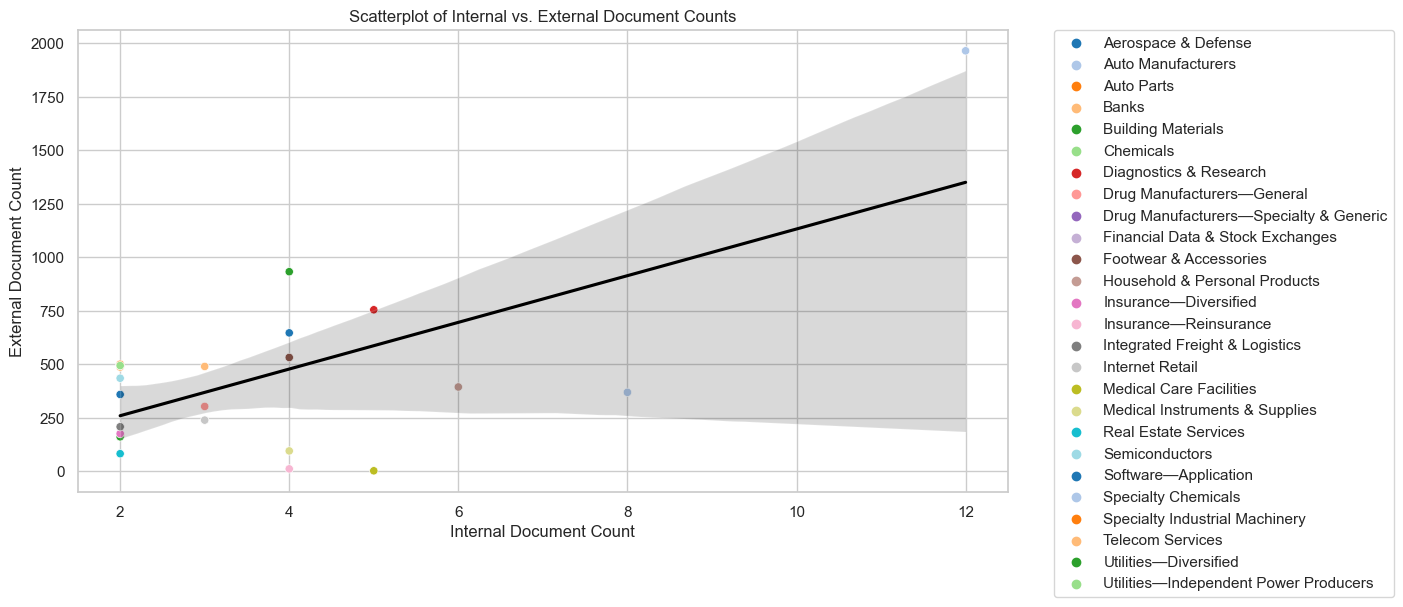

In [572]:
internal_data = cleaned_data[cleaned_data['internal'] == 1]
external_data = cleaned_data[cleaned_data['internal'] == 0]

# Calculate value counts for each subset
count_internal_datatype = internal_data['industry'].value_counts()
count_external_datatype = external_data['industry'].value_counts()

# Create a new DataFrame with internal and external document counts for each company
doc_counts = pd.DataFrame({'internal_count': count_internal_datatype, 'external_count': count_external_datatype})
doc_counts = doc_counts.reset_index().rename(columns={'index': 'industry'})

plt.figure(figsize=(12, 6))
sns.scatterplot(data=doc_counts, x='internal_count', y='external_count', hue='industry', palette='tab20')
sns.regplot(data=doc_counts, x='internal_count', y='external_count', scatter=False, color='black')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.title('Scatterplot of Internal vs. External Document Counts')
plt.xlabel('Internal Document Count')
plt.ylabel('External Document Count')
plt.show()

### Characteristic Words by Company (TFIDF)

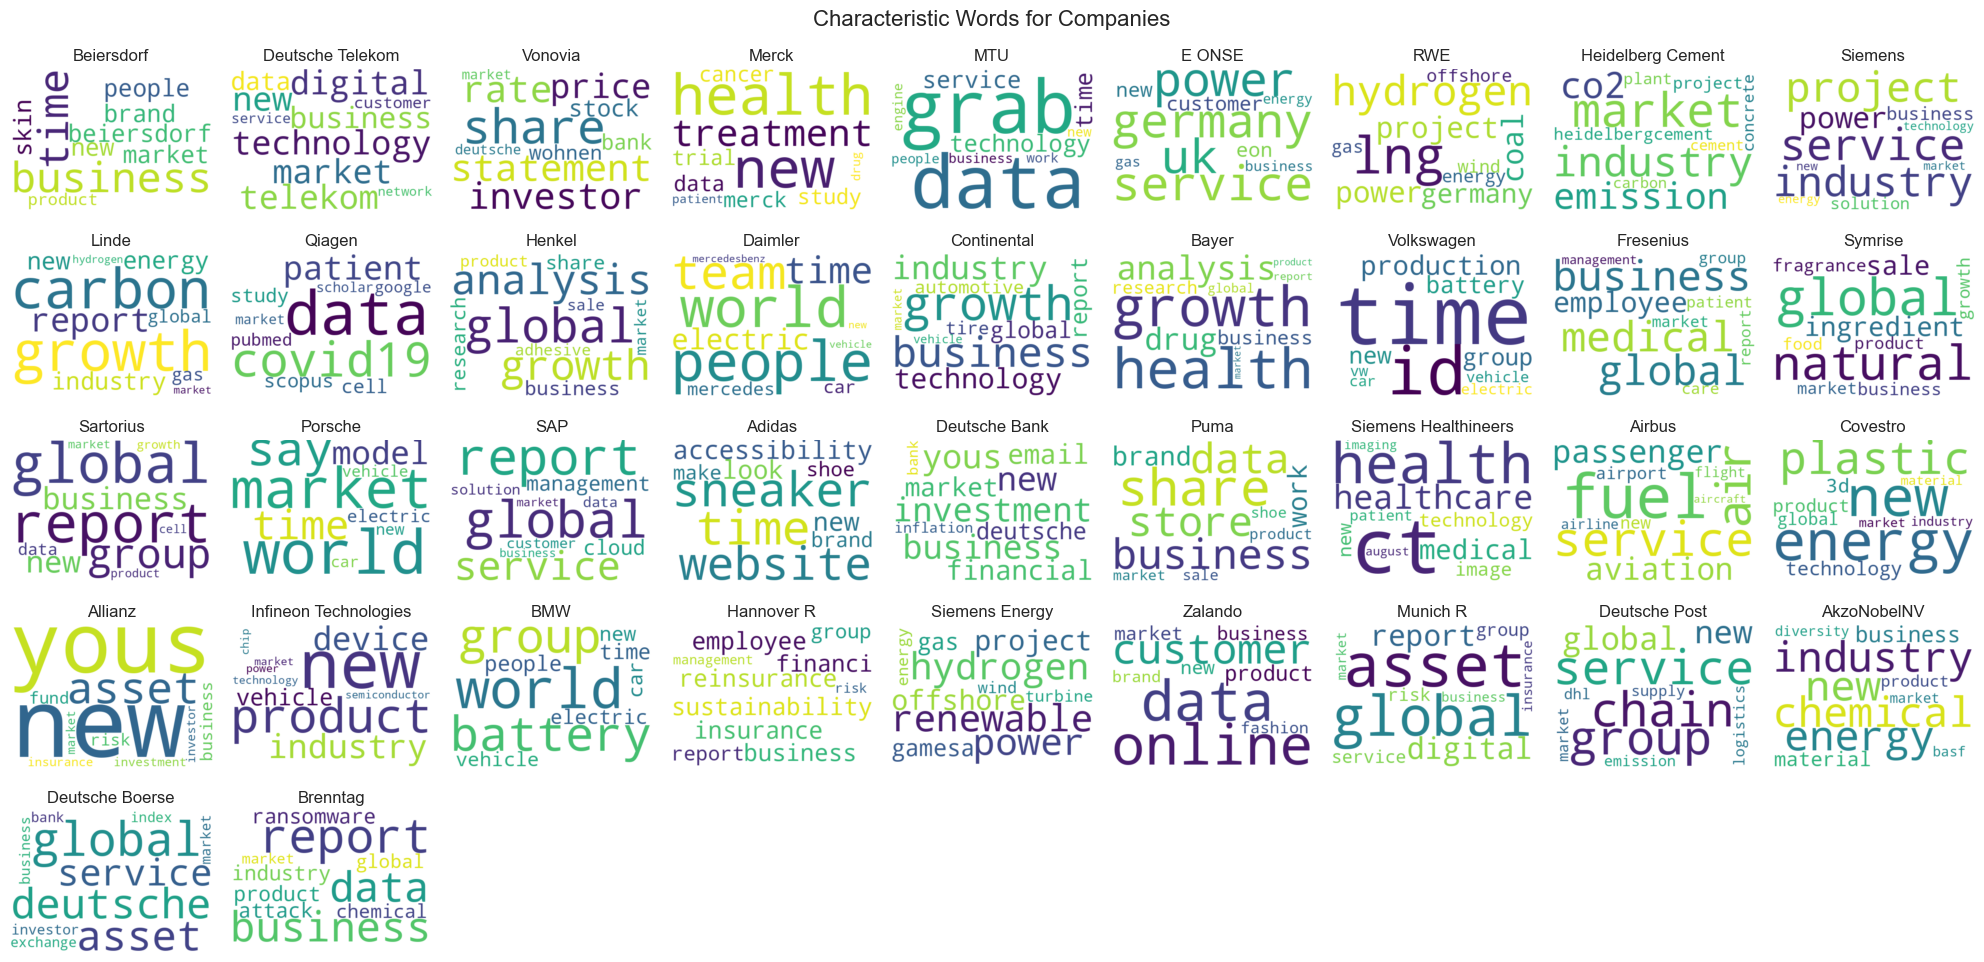

In [573]:
def characteristic_words_by_company(company, data, n=10):
    company_data = data[data['company'] == company]
    vectorizer = TfidfVectorizer(stop_words='english', max_features=100)
    X = vectorizer.fit_transform(company_data['cleaned_content'])
    top_n_indices = np.argsort(X.toarray().sum(axis=0))[-n:]
    top_n_words = np.array(vectorizer.get_feature_names_out())[top_n_indices]
    return top_n_words

companies = cleaned_data['company'].unique()
for company in companies:
    characteristic_words = characteristic_words_by_company(company, cleaned_data)
    # print(f'{company}: {', '.join(characteristic_words)}')

def plot_wordcloud_subplot(ax, company, data, n=10):
    characteristic_words = characteristic_words_by_company(company, data, n)
    wordcloud = WordCloud(width=500, height=350, background_color='white', colormap='viridis').generate(' '.join(characteristic_words))
    
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.axis('off')
    ax.set_title(f'{company}')

companies = cleaned_data['company'].unique()
n_companies = len(companies)

fig, axes = plt.subplots(nrows=int(np.ceil(n_companies/9)), ncols=9, figsize=(20, 10))
axes = axes.ravel()

for i, company in enumerate(companies):
    plot_wordcloud_subplot(axes[i], company, cleaned_data)

for i in range(n_companies, len(axes)):
    fig.delaxes(axes[i])

plt.suptitle('Characteristic Words for Companies', fontsize=16)
plt.subplots_adjust(wspace=0, hspace=0)
plt.tight_layout()
plt.show()

# Timeseries Analysis

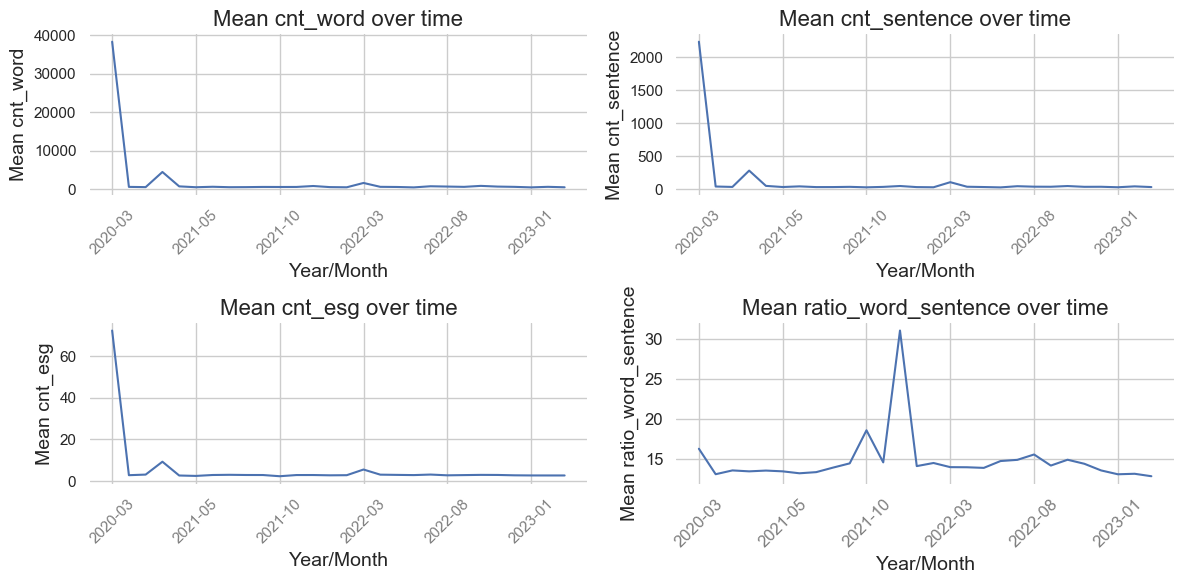

In [574]:
sns.set(style='whitegrid')

def plot_time_series(data, column, groupby_column=None, title=None, ylabel=None, start='2020-03', end='2023-03', agg_func=np.mean, ax=None, show=True):
    # Filter data based on the start and end dates
    if start:
        data = data[data['year_month'] >= start]
    if end:
        data = data[data['year_month'] <= end]

    if groupby_column:
        grouped_data = data.groupby(['year_month', groupby_column])[column].agg(agg_func).unstack()
        ax = grouped_data.plot(ax=ax, figsize=(12, 6))
        ax.legend(title=groupby_column, bbox_to_anchor=(1.05, 1), loc='upper left')
    else:
        grouped_data = data.groupby('year_month')[column].agg(agg_func)
        ax = grouped_data.plot(ax=ax, figsize=(12, 6))

    # Customize the plot aesthetics
    ax.set_title(title or f'{agg_func.__name__.capitalize()} {column} over time', fontsize=16)
    ax.set_xlabel('Year/Month', fontsize=14)
    ax.set_ylabel(ylabel or f'{agg_func.__name__.capitalize()} {column}', fontsize=14)
    plt.xticks(rotation=45, fontsize=12)
    for label in ax.get_xticklabels():
        label.set_rotation(45)
        label.set_color('grey')
    plt.yticks(fontsize=12)
    sns.despine(left=True, bottom=True)

    if show:
        plt.tight_layout()
        plt.show()


fig, axes = plt.subplots(2, 2, figsize=(18, 12))

plot_time_series(cleaned_data, 'cnt_word', ax=axes[0, 0], show=False)
plot_time_series(cleaned_data, 'cnt_sentence', ax=axes[0, 1], show=False)
plot_time_series(cleaned_data, 'cnt_esg', ax=axes[1, 0], show=False)
plot_time_series(cleaned_data, 'ratio_word_sentence', ax=axes[1, 1], show=False)
# plot_time_series(cleaned_data, 'cnt_word', start=start_date, end=end_date, agg_func=np.sum, ax=axes[1, 1], show=False)

plt.tight_layout()
plt.show()

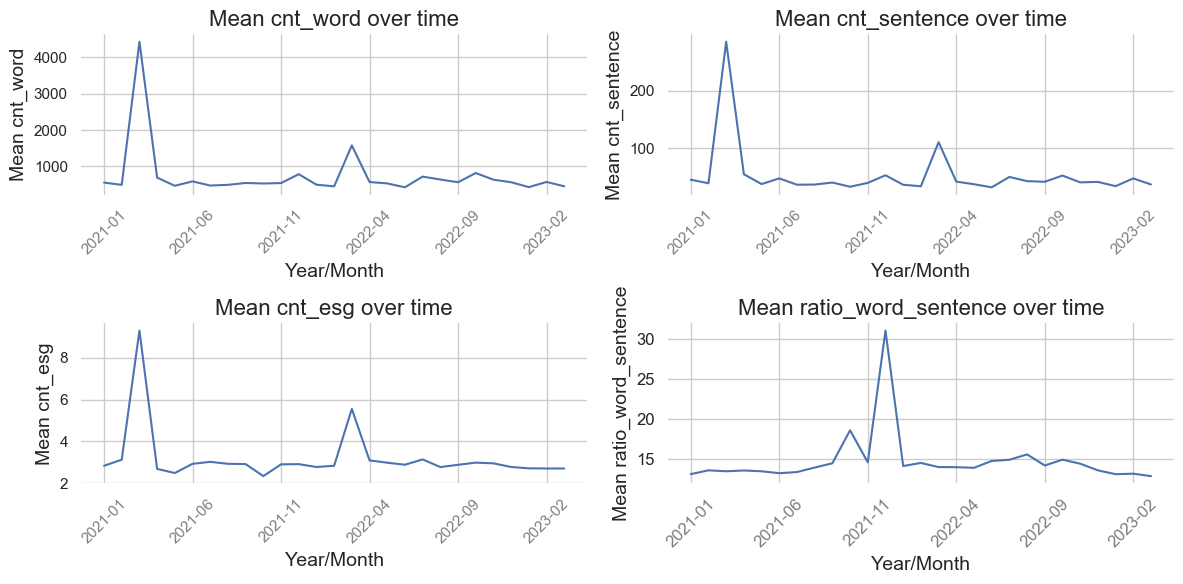

In [575]:
fig, axes = plt.subplots(2, 2, figsize=(18, 12))

plot_time_series(cleaned_data, 'cnt_word', start='2020-05', ax=axes[0, 0], show=False)
plot_time_series(cleaned_data, 'cnt_sentence', start='2020-05', ax=axes[0, 1], show=False)
plot_time_series(cleaned_data, 'cnt_esg', start='2020-05', ax=axes[1, 0], show=False)
plot_time_series(cleaned_data, 'ratio_word_sentence', start='2020-05', ax=axes[1, 1], show=False)
# plot_time_series(cleaned_data, 'cnt_word', start=start_date, end=end_date, agg_func=np.sum, ax=axes[1, 1], show=False)

plt.tight_layout()
plt.show()

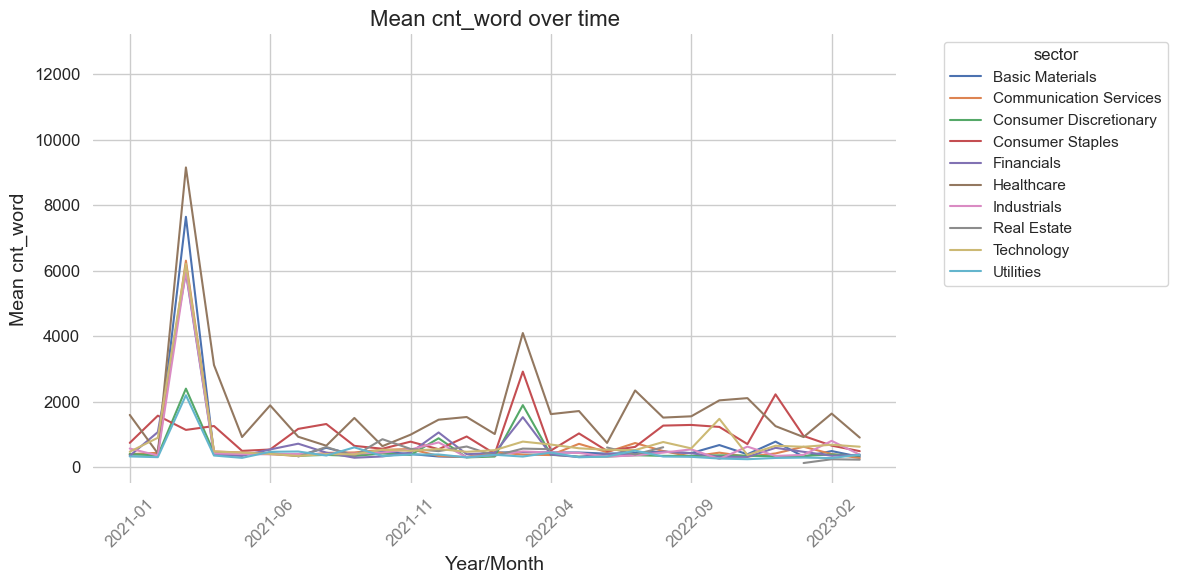

In [576]:
# Average 'cnt_word' over time by 'sector'
plot_time_series(cleaned_data, 'cnt_word', 'sector', start='2020-05',show=True)

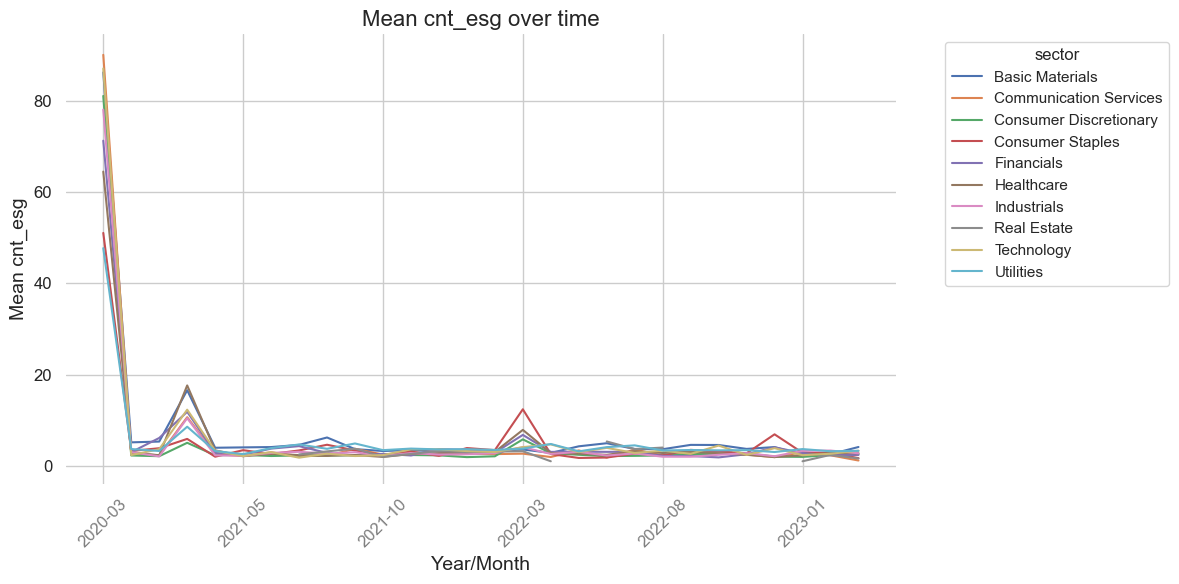

In [577]:
# Average 'cnt_esg' over time by 'sector'
plot_time_series(cleaned_data, 'cnt_esg', 'sector')

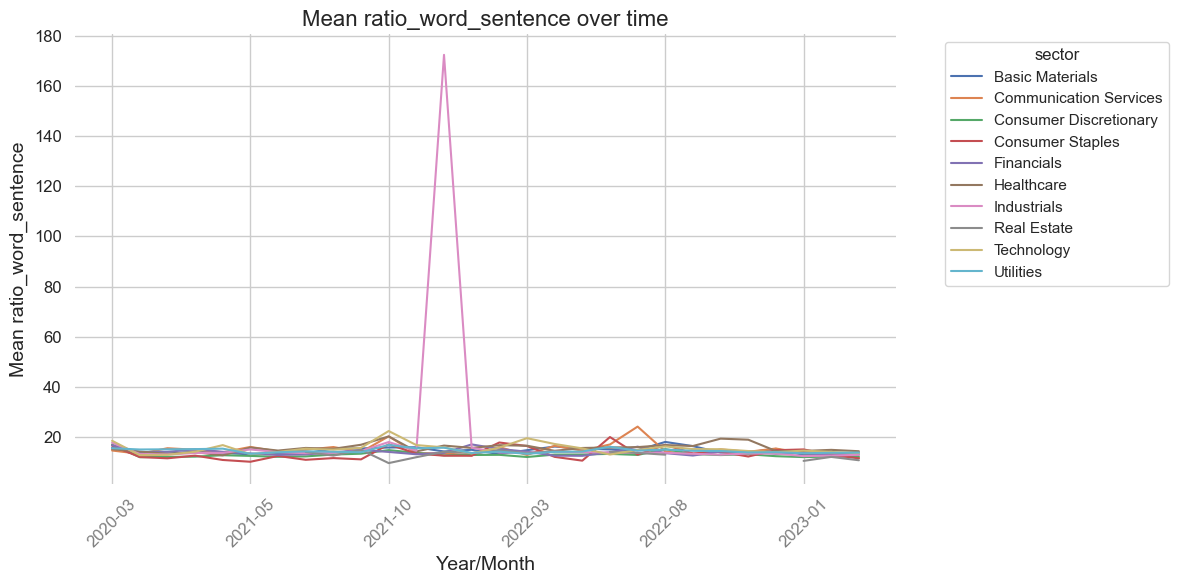

In [578]:
# Average 'ratio_word_sentence' over time by 'sector'
plot_time_series(cleaned_data, 'ratio_word_sentence', 'sector')

# Sentiment Analysis / Polarity of the Reports

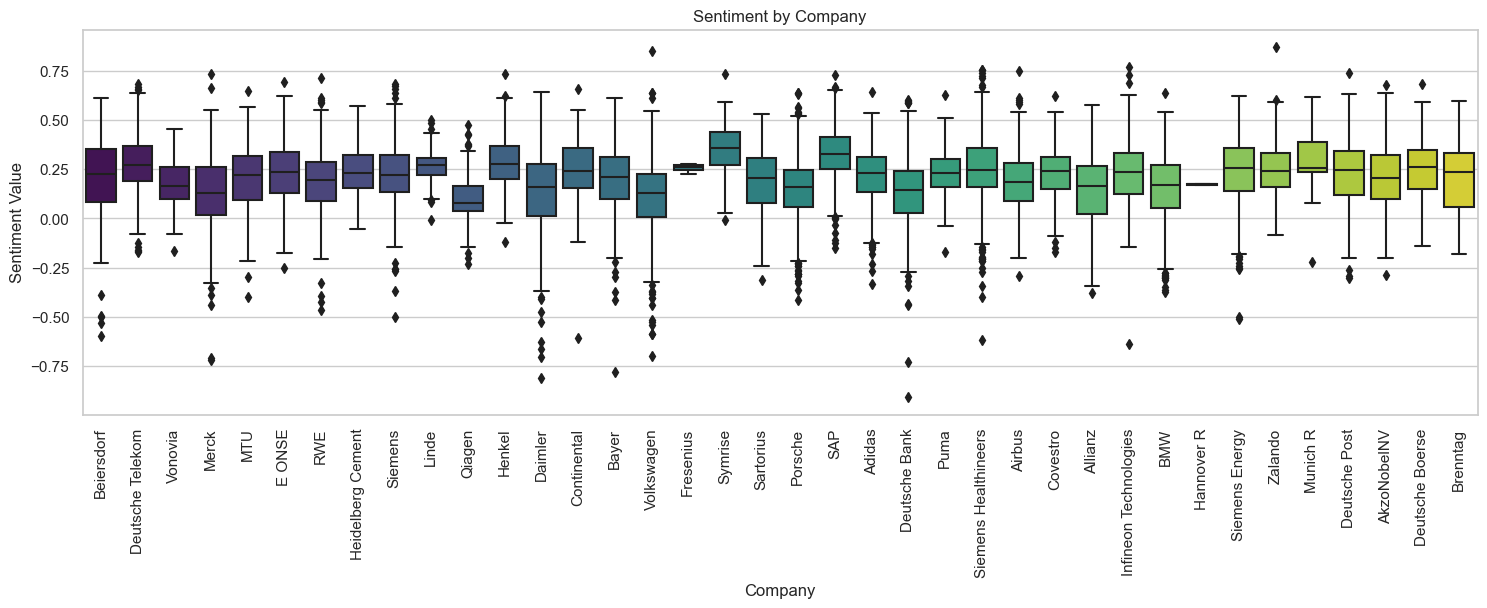

In [579]:
plt.figure(figsize=(18, 5))
sns.boxplot(data=cleaned_data, x='company', y='sentiment_value', palette='viridis')
plt.title('Sentiment by Company')
plt.xlabel('Company')
plt.ylabel('Sentiment Value')
plt.xticks(rotation=90)
plt.show()

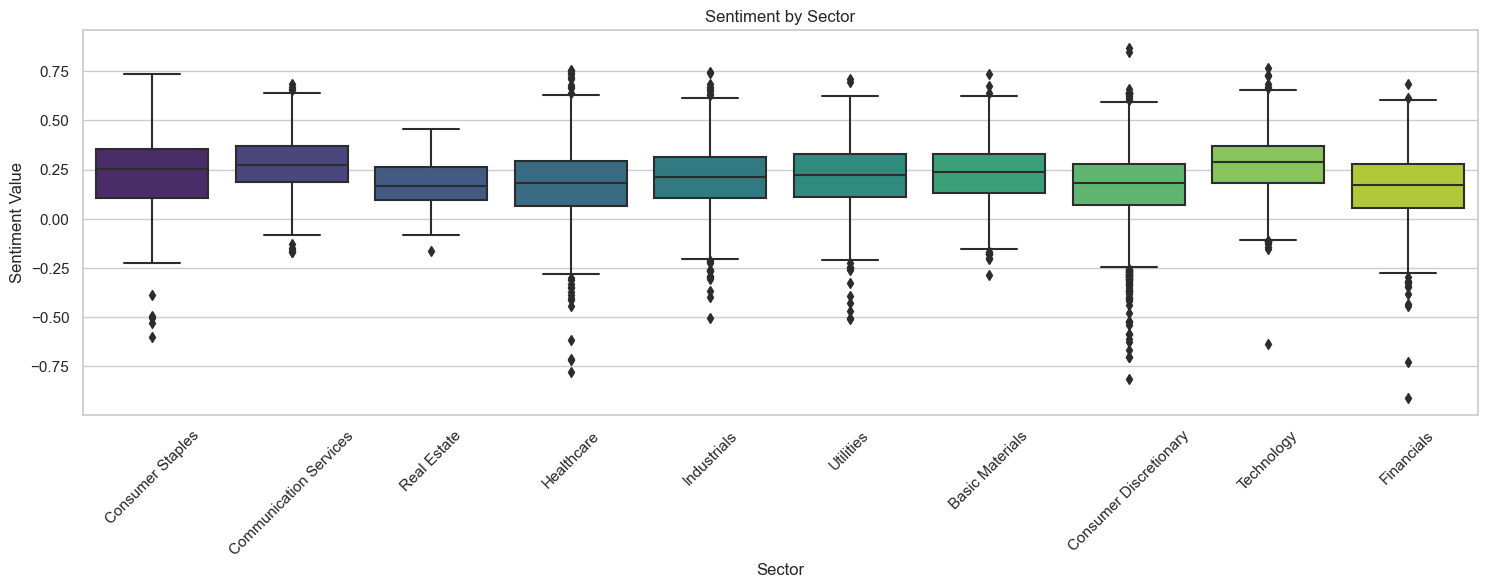

In [580]:
plt.figure(figsize=(18, 5))
sns.boxplot(data=cleaned_data, x='sector', y='sentiment_value', palette='viridis')
plt.title('Sentiment by Sector')
plt.xlabel('Sector')
plt.ylabel('Sentiment Value')
plt.xticks(rotation=45)
plt.show()

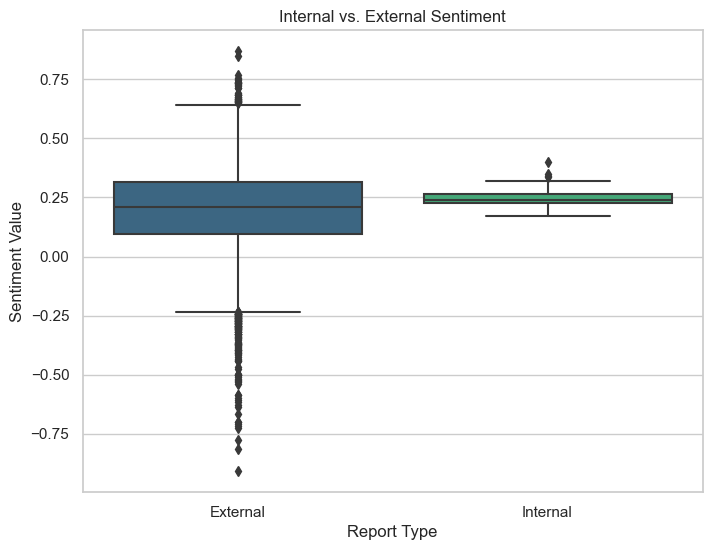

In [581]:
plt.figure(figsize=(8, 6))
sns.boxplot(data=cleaned_data, x='internal', y='sentiment_value', palette='viridis')
plt.title('Internal vs. External Sentiment')
plt.xlabel('Report Type')
plt.ylabel('Sentiment Value')
plt.xticks([0, 1], ['External', 'Internal'])
plt.show()

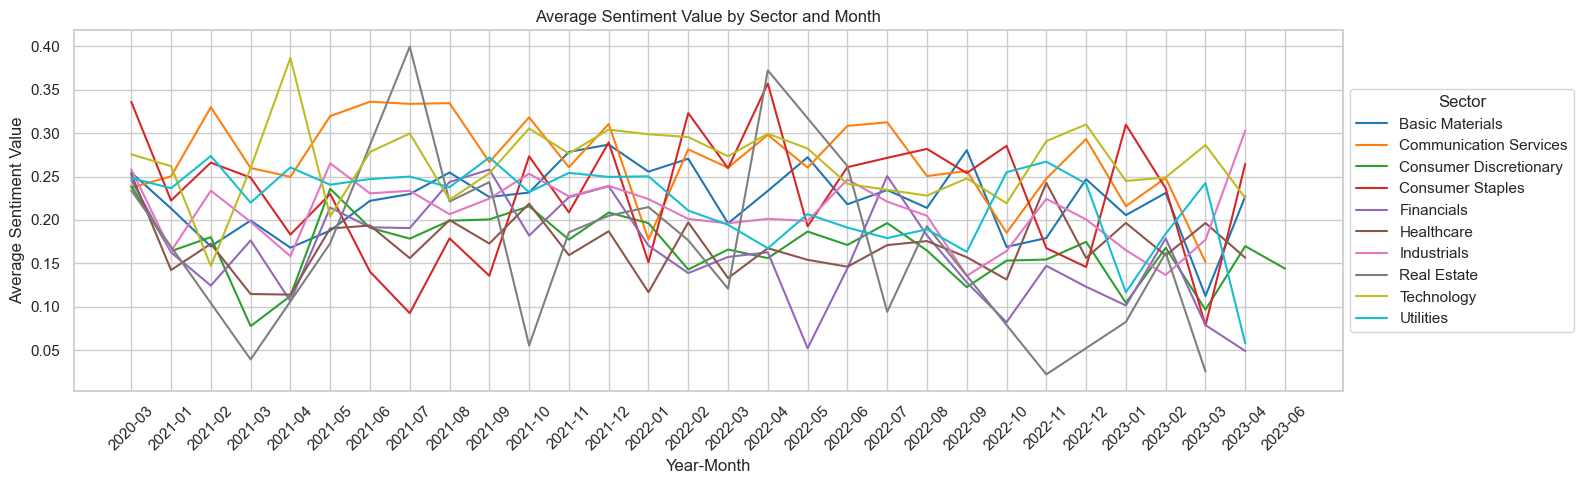

In [582]:
plt.figure(figsize=(16, 5))

# Aggregate sentiment value by sector and year_month
sentiment_by_sector_month = cleaned_data.groupby(['sector', 'year_month']).agg({'sentiment_value': 'mean'}).reset_index()

sns.lineplot(data=sentiment_by_sector_month, x='year_month', y='sentiment_value', hue='sector', palette='tab10')
plt.title('Average Sentiment Value by Sector and Month')
plt.xlabel('Year-Month')
plt.ylabel('Average Sentiment Value')
plt.xticks(rotation=45)
plt.legend(title='Sector', loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

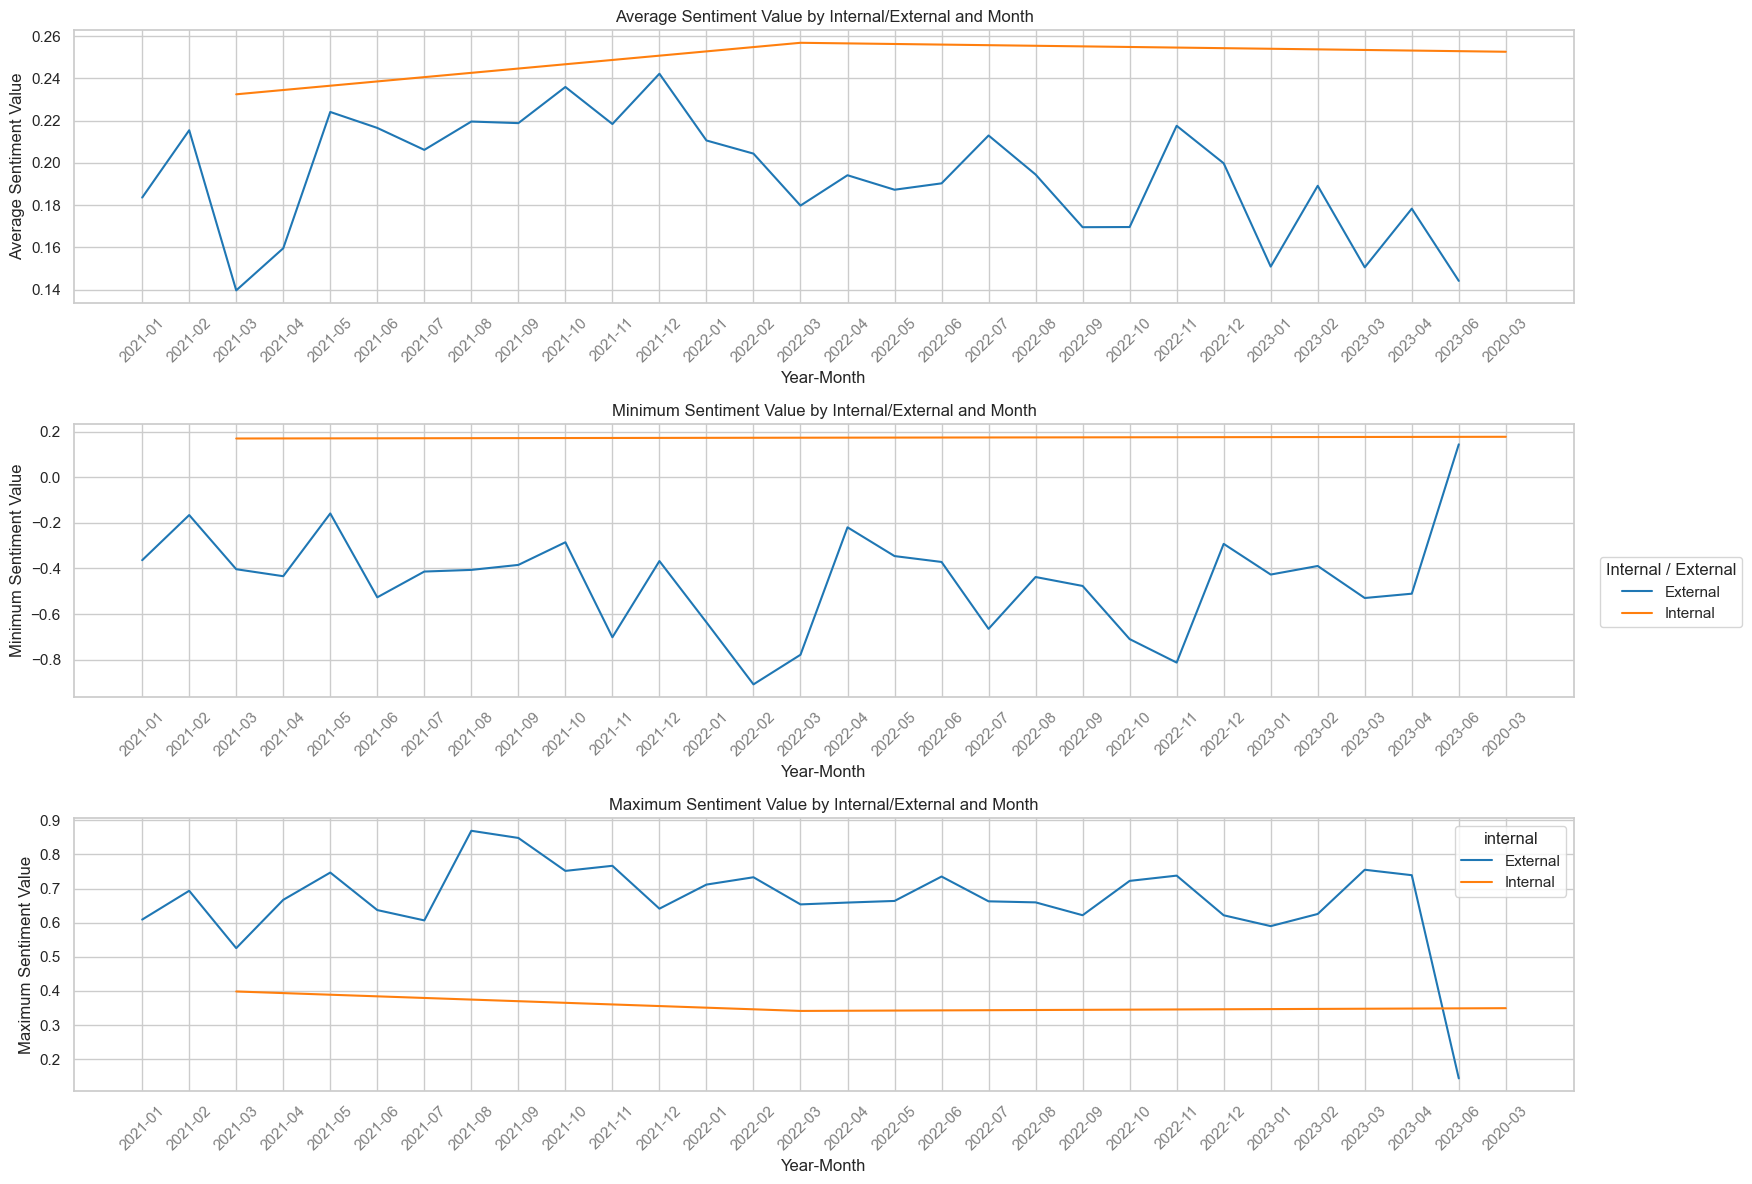

In [583]:
fig, axes = plt.subplots(3, 1, figsize=(16, 12))

# Aggregate sentiment value by internal/external and year_month
sentiment_by_internal_month = cleaned_data.groupby(['internal', 'year_month']).agg({'sentiment_value': ['mean', 'min', 'max']}).reset_index()

# Replace internal values (0, 1) with 'External' and 'Internal'
sentiment_by_internal_month['internal'] = sentiment_by_internal_month['internal'].replace({0: 'External', 1: 'Internal'})

# Flatten the columns for easier plotting
sentiment_by_internal_month.columns = ['_'.join(col).rstrip('_') for col in sentiment_by_internal_month.columns.values]

# Plot the timeseries for average sentiment value
ax1 = sns.lineplot(ax=axes[0], data=sentiment_by_internal_month, x='year_month', y='sentiment_value_mean', hue='internal', palette='tab10', hue_order=['External', 'Internal'])
axes[0].set_title('Average Sentiment Value by Internal/External and Month')
axes[0].set_xlabel('Year-Month')
axes[0].set_ylabel('Average Sentiment Value')
axes[0].tick_params(axis='x', rotation=45, labelcolor='grey')

# Plot the timeseries for minimum sentiment value
ax2 = sns.lineplot(ax=axes[1], data=sentiment_by_internal_month, x='year_month', y='sentiment_value_min', hue='internal', palette='tab10', hue_order=['External', 'Internal'])
axes[1].set_title('Minimum Sentiment Value by Internal/External and Month')
axes[1].set_xlabel('Year-Month')
axes[1].set_ylabel('Minimum Sentiment Value')
axes[1].tick_params(axis='x', rotation=45, labelcolor='grey')

# Plot the timeseries for maximum sentiment value
ax3 = sns.lineplot(ax=axes[2], data=sentiment_by_internal_month, x='year_month', y='sentiment_value_max', hue='internal', palette='tab10', hue_order=['External', 'Internal'])
axes[2].set_title('Maximum Sentiment Value by Internal/External and Month')
axes[2].set_xlabel('Year-Month')
axes[2].set_ylabel('Maximum Sentiment Value')
axes[2].tick_params(axis='x', rotation=45, labelcolor='grey')

# Remove the legends from the individual subplots
ax1.get_legend().remove()
ax2.get_legend().remove()

# Create a single legend for all the plots and set its position to the right side of the plot
handles, labels = ax1.get_legend_handles_labels()
legend = fig.legend(handles, labels, title='Internal / External', loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()
plt.show()

/var/folders/9k/tdnv785s1hx8x68mq3f94lzw0000gn/T/ipykernel_99806/2962008862.py:11: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(ax=axes[0], data=mean_internal_sentiment_by_month, x='year_month', y='sentiment_value_mean', marker='o', palette='tab10')
/var/folders/9k/tdnv785s1hx8x68mq3f94lzw0000gn/T/ipykernel_99806/2962008862.py:18: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(ax=axes[1], data=mean_external_sentiment_by_month, x='year_month', y='sentiment_value_mean', marker='o', palette='tab10')


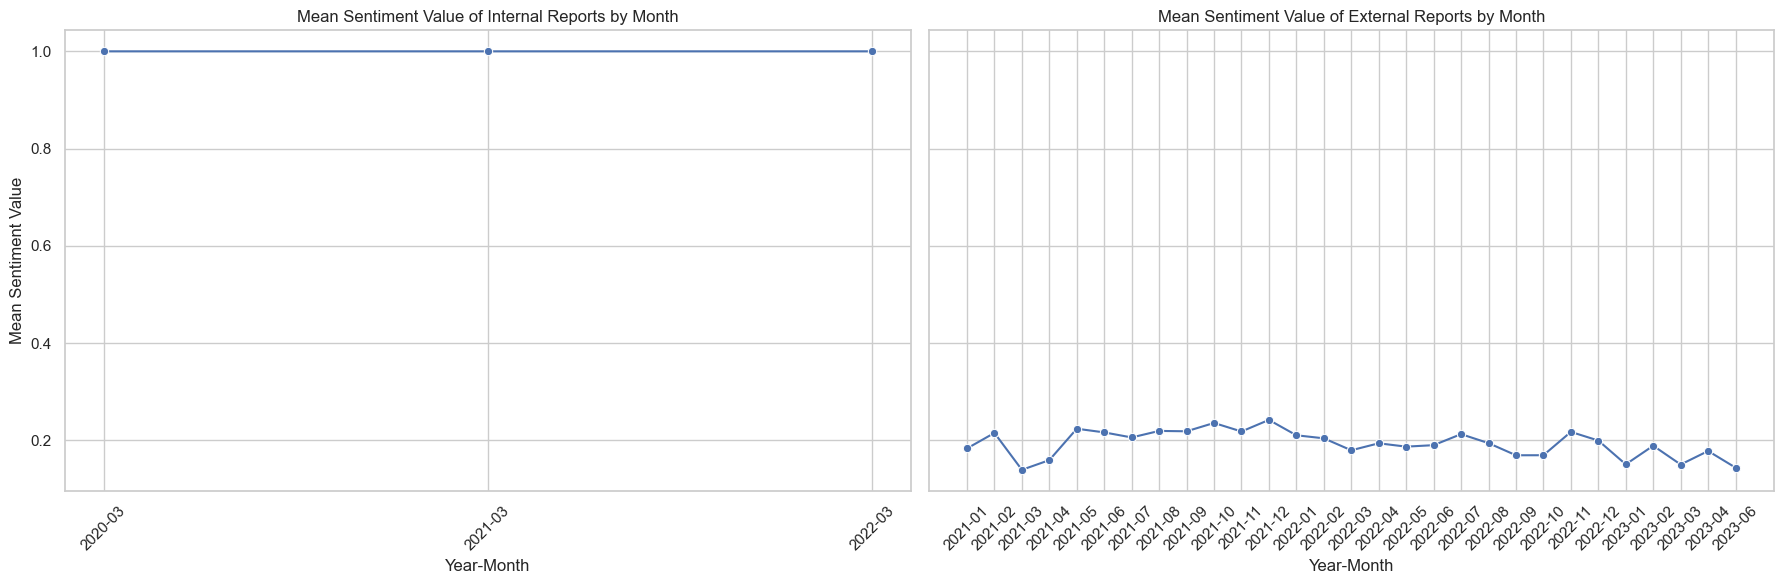

In [584]:
# Filter the sentiment_by_internal_month DataFrame to include only the external reports
external_sentiment_by_month = sentiment_by_internal_month[sentiment_by_internal_month['internal'] == 'External']

# Aggregate the sentiment by year_month and calculate the mean sentiment
mean_external_sentiment_by_month = external_sentiment_by_month.groupby('year_month')['sentiment_value_mean'].mean().reset_index()

# Create the combined plot
fig, axes = plt.subplots(1, 2, figsize=(18, 6), sharey=True)

# Plot the mean sentiment value of internal reports
sns.lineplot(ax=axes[0], data=mean_internal_sentiment_by_month, x='year_month', y='sentiment_value_mean', marker='o', palette='tab10')
axes[0].set_title('Mean Sentiment Value of Internal Reports by Month')
axes[0].set_xlabel('Year-Month')
axes[0].set_ylabel('Mean Sentiment Value')
axes[0].tick_params(axis='x', rotation=45)

# Plot the mean sentiment value of external reports
sns.lineplot(ax=axes[1], data=mean_external_sentiment_by_month, x='year_month', y='sentiment_value_mean', marker='o', palette='tab10')
axes[1].set_title('Mean Sentiment Value of External Reports by Month')
axes[1].set_xlabel('Year-Month')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In [585]:
cleaned_data.sample(5)

company  datatype       date                  domain   
2361           Bayer  business 2021-12-13          marketscreener  \
9274  Siemens Energy  business 2021-07-29          marketscreener   
7433         Porsche      tech 2022-05-19  interestingengineering   
1868             BMW      tech 2021-01-29          digitaljournal   
3057     Continental      tech 2021-12-07        supplychainbrain   

                                          esg_topics  internal symbol   
2361                         [Pesticide, Carcinogen]         0   BAYN  \
9274                               [RenewableEnergy]         0    ENR   
7433                            [EMobility, Privacy]         0   PAH3   
1868  [AntiCorruption, Oversight, RussianFederation]         0    BMW   
3057    [HumanCapital, PlantBasedFood, Renumeration]         0    CON   

                                                  title   
2361  Supreme Court asks U.S. government for views o...  \
9274  Siemens Gamesa Renewable Energy S A: Third Qua...   
7433  Bentley Electric Car: Bentley enters the EV ma...   
1868  Navalny brother, aides under house arrest ahea...   
3057  The World's Relentless Demand for Chips Turns ...   

                                        cleaned_content   
2361  yous supreme court monday asked president admi...  \
9274     distributed public unedited unaltered july utc   
7433  centuryold british automotive brand celebrated...   
1868  hi looking published brother aide jailed kreml...   
3057  facility malaysia prided working hard provide ...   

                                            word_tokens  ...   
2361  [yous, supreme, court, monday, asked, presiden...  ...  \
9274  [distributed, public, unedited, unaltered, jul...  ...   
7433  [centuryold, british, automotive, brand, celeb...  ...   
1868  [hi, looking, published, brother, aide, jailed...  ...   
3057  [facility, malaysia, prided, working, hard, pr...  ...   

                      sector                               industry   
2361              Healthcare             Drug Manufacturers—General  \
9274               Utilities  Utilities—Independent Power Producers   
7433  Consumer Discretionary                     Auto Manufacturers   
1868  Consumer Discretionary                     Auto Manufacturers   
3057  Consumer Discretionary                             Auto Parts   

     sentiment_value  cnt_word cnt_sentence cnt_esg  ratio_word_sentence   
2361        0.036574       330           31       2            10.645161  \
9274        0.000000         6            2       1             3.000000   
7433        0.056727       268           26       2            10.307692   
1868       -0.278132       883           72       3            12.263889   
3057       -0.009331      1704          168       3            10.142857   

      year_month  year  month  
2361     2021-12  2021     12  
9274     2021-07  2021     07  
7433     2022-05  2022     05  
1868     2021-01  2021     01  
3057     2021-12  2021     12  

[5 rows x 24 columns]

# Word Embedding Visualization with Word2Vec

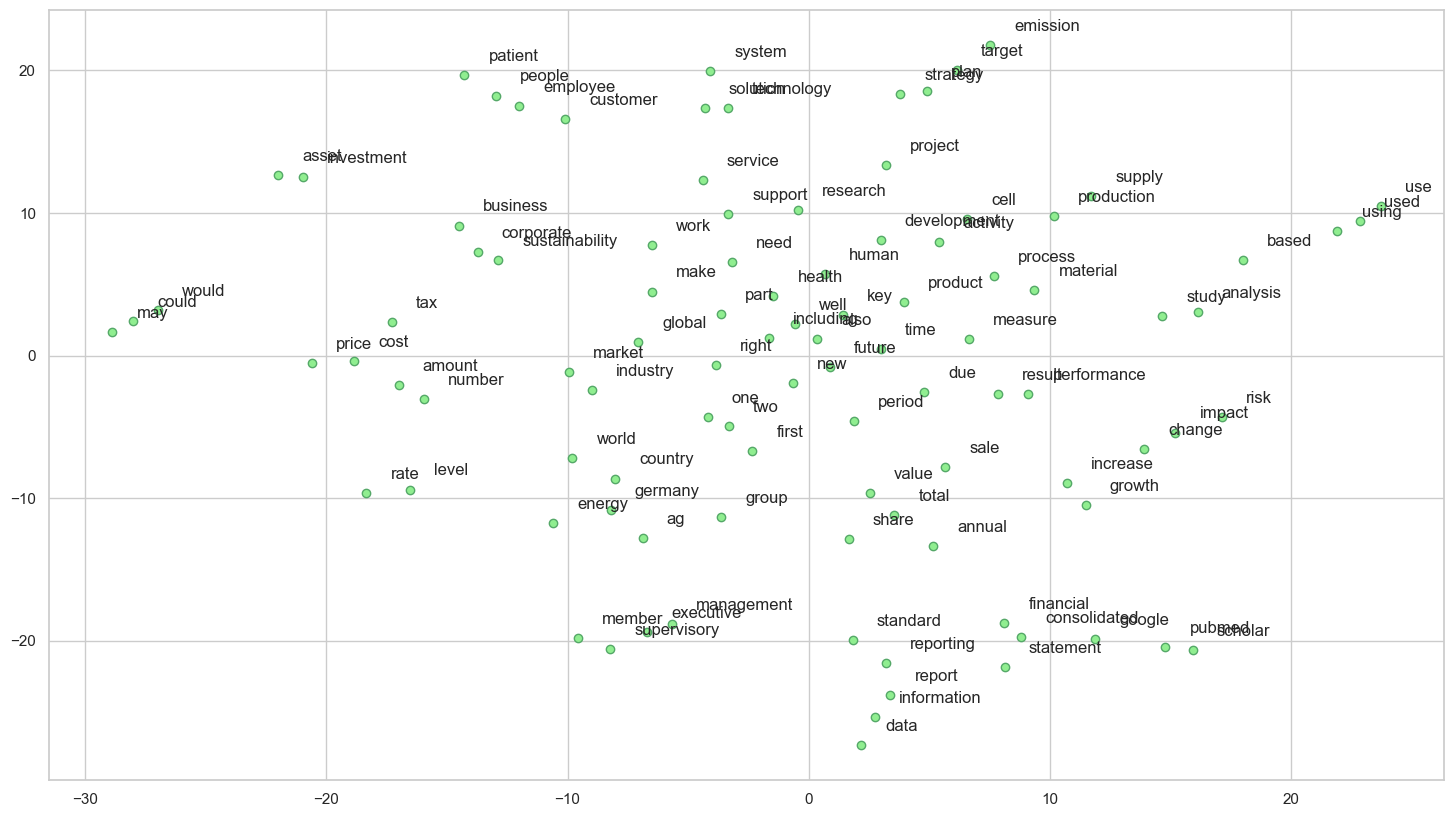

In [586]:
all_words = [word for word_list in cleaned_data['word_tokens'] for word in word_list]

# Count the occurrences of each word and find the top 100 words
word_counts = Counter(all_words)
top_100_words = [word for word, _ in word_counts.most_common(100)]

# Train a Word2Vec model on the combined words with a fixed seed (42 is always the answer)
w2vmodel = Word2Vec(cleaned_data['word_tokens'], vector_size=100, window=5, min_count=1, workers=4, seed=42)

# Get the embeddings of the top 100 words
wvs = w2vmodel.wv[top_100_words]

# Use t-SNE to reduce the dimensions of the embeddings with a fixed seed
tsne = TSNE(n_components=2, random_state=42, n_iter=10000, perplexity=5)
T = tsne.fit_transform(wvs)
labels = top_100_words

plt.figure(figsize=(18, 10))
plt.scatter(T[:, 0], T[:, 1], c='lightgreen', edgecolors='g')
for label, x, y in zip(labels, T[:, 0], T[:, 1]):
    plt.annotate(label,
                 xy=(x + 1, y + 1),
                 xytext=(0, 0),
                 textcoords='offset points')

plt.show()

## ESG Topic Exploration

### Top X ESG Topic Distribution over Time

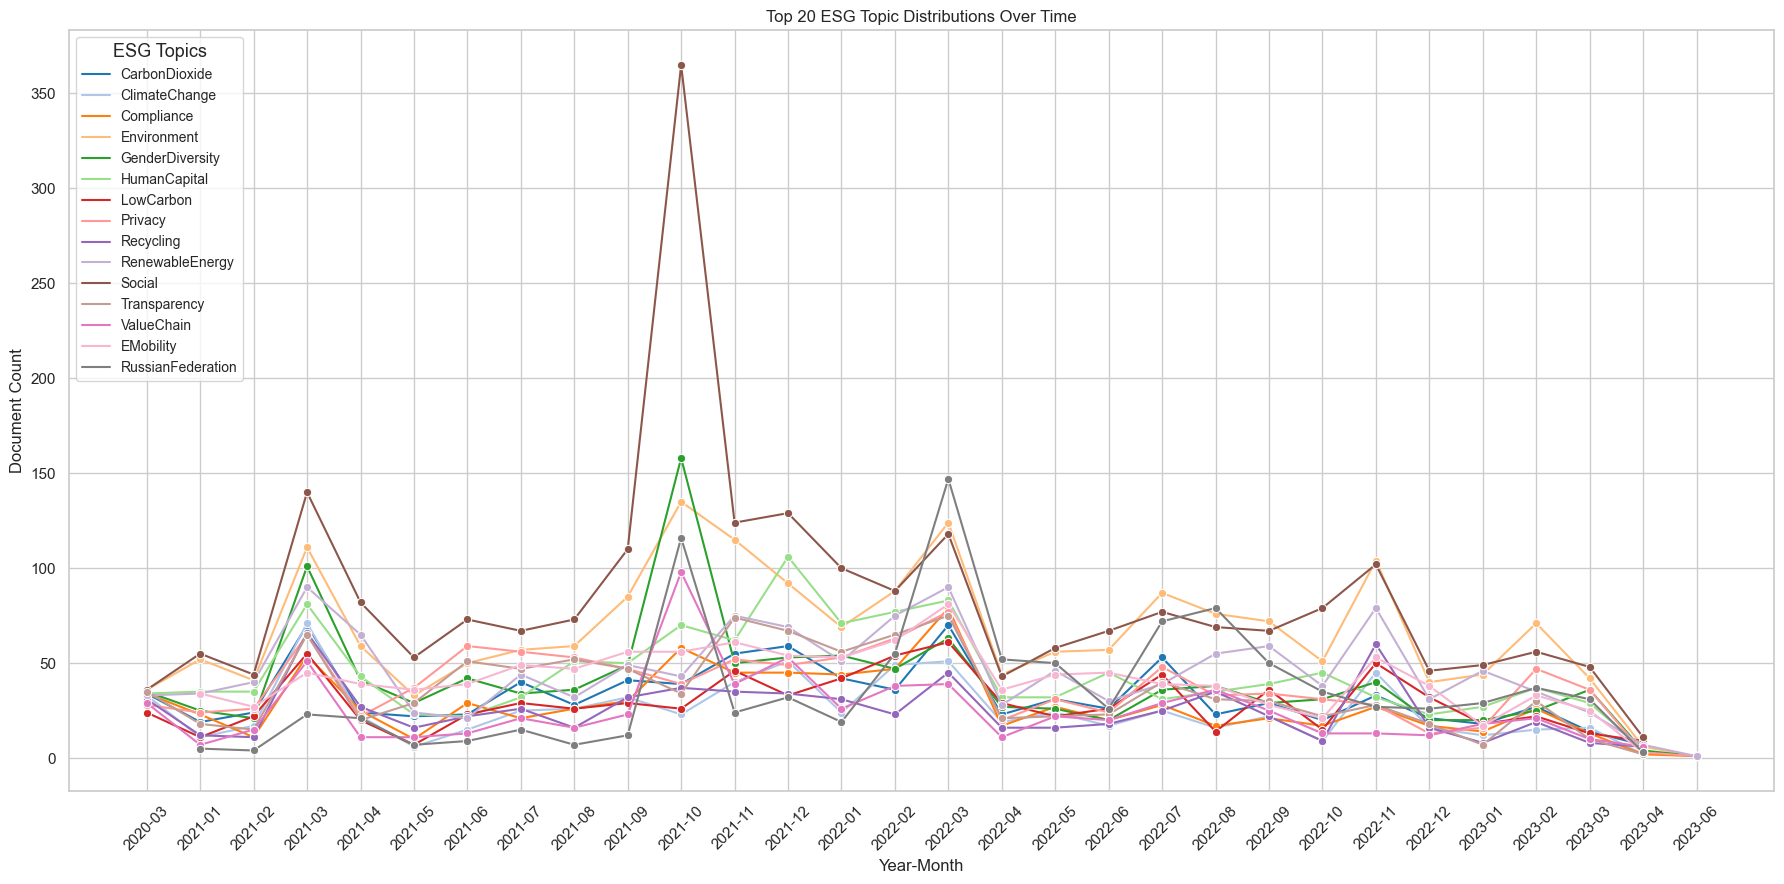

In [587]:
topic_timeseries = cleaned_data.explode('esg_topics').groupby(['year_month', 'esg_topics']).size().reset_index(name='count')

# Calculate the total count of each ESG topic
total_topic_count = topic_timeseries.groupby('esg_topics')['count'].sum().reset_index(name='total_count')

# Get the top 20 ESG topics
top_20_esg_topics = total_topic_count.nlargest(15, 'total_count')['esg_topics'].tolist()
filtered_topic_timeseries = topic_timeseries[topic_timeseries['esg_topics'].isin(top_20_esg_topics)]

plt.figure(figsize=(18, 9))
sns.lineplot(data=filtered_topic_timeseries, x='year_month', y='count', hue='esg_topics', marker='o', palette='tab20')
plt.title('Top 20 ESG Topic Distributions Over Time')
plt.xlabel('Year-Month')
plt.ylabel('Document Count')
plt.xticks(rotation=45)
plt.legend(title='ESG Topics', title_fontsize='13', loc='upper left', fontsize='10')
plt.tight_layout()
plt.show()
